# Lorenz System Initial Condition Optimization

## Problem Overview

The **Lorenz system** is a classical example of a chaotic dynamical system, defined by the differential equations:


\begin{cases}
\dot{x} = \sigma (y - x) \\
\dot{y} = x (\rho - z) - y \\
\dot{z} = xy - \beta z
\end{cases}

with standard parameters:

$\sigma = 10,
\rho = 28,
\beta = 8/3$

The system exhibits **deterministic chaos**, meaning small changes in the initial state lead to drastically different trajectories over time.

---

## Goal

In this notebook, we aim to **find an initial condition** that drives the Lorenz system as close as possible to a **desired target final state** at a fixed future time \(T\).  

Formally, we solve the optimization problem:


$\min_{x_0} \; \| x(T; x_0) - x_\text{target} \|_2^2 $

Where:

- $x_0 = [x(0), y(0), z(0)] $ is the initial condition (learnable)  
- $x(T; x_0) $ is the state at final time $T$ after integrating the Lorenz ODE  
- $x_\text{target}$ is the desired final state  
- The loss is the **squared L2 distance** between final state and target

---

## Approach

1. **Differentiable Lorenz Solver**  
   - Implemented an RK4 integrator using PyTorch, making integration fully differentiable.  

2. **Learnable Initial Condition**  
   - Treat the initial state `x0` as a PyTorch parameter (`requires_grad=True`)  

3. **Backpropagation Through ODE**  
   - Compute the L2 loss at the final time  
   - Backpropagate through the integrator to update the initial condition  

4. **Tracking Best Solution**  
   - Keep track of the trajectory and initial condition that produce the minimum loss observed so far  


## Define the dynamics, first sanity check run

In [91]:
import torch
from torch import Tensor
from torch.utils.data import Dataset
from typing import Tuple, Optional


def lorenz_deriv(state: Tensor, sigma: float = 10.0, rho: float = 28.0, beta: float = 8.0/3.0) -> Tensor:
    """
    Compute Lorenz derivatives.

    Args:
        state: tensor of shape (..., 3) representing [x, y, z]
        sigma, rho, beta: Lorenz parameters

    Returns:
        derivatives tensor with same shape as state
    """
    x = state[..., 0]
    y = state[..., 1]
    z = state[..., 2]

    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z

    return torch.stack((dx, dy, dz), dim=-1)


def rk4_step(f, state: Tensor, dt: float, *f_args, **f_kwargs) -> Tensor:
    """
    Single RK4 step for the ODE state' = f(state).

    Args:
        f: function(state, *f_args, **f_kwargs) -> derivatives (..., D)
        state: tensor (..., D)
        dt: timestep (scalar)
        f_args, f_kwargs: extra args passed to f

    Returns:
        next_state tensor (..., D)
    """
    k1 = f(state, *f_args, **f_kwargs)
    k2 = f(state + 0.5 * dt * k1, *f_args, **f_kwargs)
    k3 = f(state + 0.5 * dt * k2, *f_args, **f_kwargs)
    k4 = f(state + dt * k3, *f_args, **f_kwargs)

    return state + (dt / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)


def integrate_lorenz(
    initial_state: Tensor,
    n_steps: int,
    dt: float,
    sigma: float = 10.0,
    rho: float = 28.0,
    beta: float = 8.0/3.0,
    device: Optional[torch.device] = None,
    dtype: Optional[torch.dtype] = None,
    return_times: bool = False,
) -> Tensor:
    """
    Integrate Lorenz system using RK4.

    Args:
        initial_state: tensor of shape (batch, 3) or (3,) (will be unsqueezed to batch dim)
        n_steps: number of integration steps to take
        dt: time step
        sigma, rho, beta: Lorenz parameters
        device, dtype: optional device/dtype override
        return_times: if True returns (times, trajectory), else just trajectory

    Returns:
        trajectory tensor of shape (n_steps+1, batch, 3) (first entry is initial_state)
        (optional) times tensor of shape (n_steps+1,)
    """
    if device is None:
        device = initial_state.device if isinstance(initial_state, Tensor) else torch.device("cpu")
    if dtype is None:
        dtype = initial_state.dtype if isinstance(initial_state, Tensor) else torch.get_default_dtype()

    state = initial_state.clone().to(device=device, dtype=dtype)
    if state.dim() == 1:
        state = state.unsqueeze(0)  # (1, 3)

    batch = state.shape[0]
    traj = torch.empty((n_steps + 1, batch, 3), device=device, dtype=dtype)
    traj[0] = state

    for i in range(1, n_steps + 1):
        state = rk4_step(lorenz_deriv, state, dt, sigma, rho, beta)
        traj[i] = state

    if return_times:
        times = torch.arange(0, (n_steps + 1) * dt, dt, device=device, dtype=dtype)
        return times, traj
    return traj



In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64  # using float64 can help with chaotic systems' integration accuracy

init = torch.tensor([1.0, 1.0, 1.0], dtype=dtype, device=device)
n_steps = 5000
dt = 0.01

# Integrate (this returns (n_steps+1, 1, 3))
traj = integrate_lorenz(init, n_steps=n_steps, dt=dt, sigma=10.0, rho=28.0, beta=8.0/3.0, device=device, dtype=dtype)
print("trajectory shape:", traj.shape)  # -> (10001, 1, 3)

trajectory shape: torch.Size([5001, 1, 3])


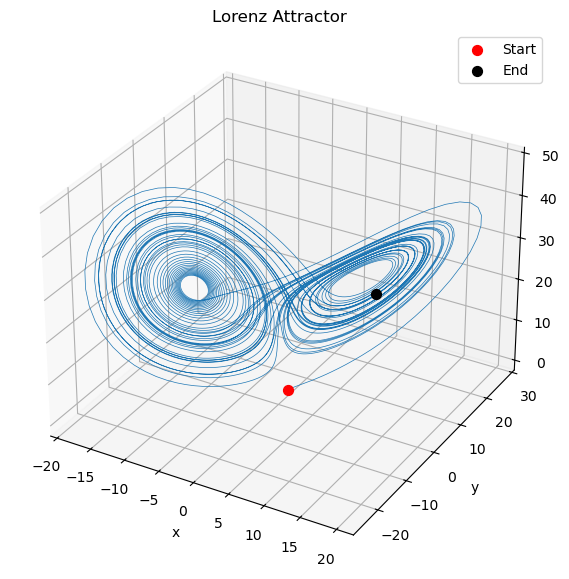

In [93]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # registers 3D projection

xyz = traj[:, 0].detach().cpu().numpy()  # convert to NumPy

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory
ax.plot(xyz[:, 0], xyz[:, 1], xyz[:, 2], linewidth=0.5)

# Mark the first point (red) and last point (black)
ax.scatter(xyz[0, 0], xyz[0, 1], xyz[0, 2], color='red', s=50, label='Start')
ax.scatter(xyz[-1, 0], xyz[-1, 1], xyz[-1, 2], color='black', s=50, label='End')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("Lorenz Attractor")

plt.legend()
plt.show()


## First test: Solve optimization problem for short time (before trajectories diverge)

First, find the time that trajectories start to differ.

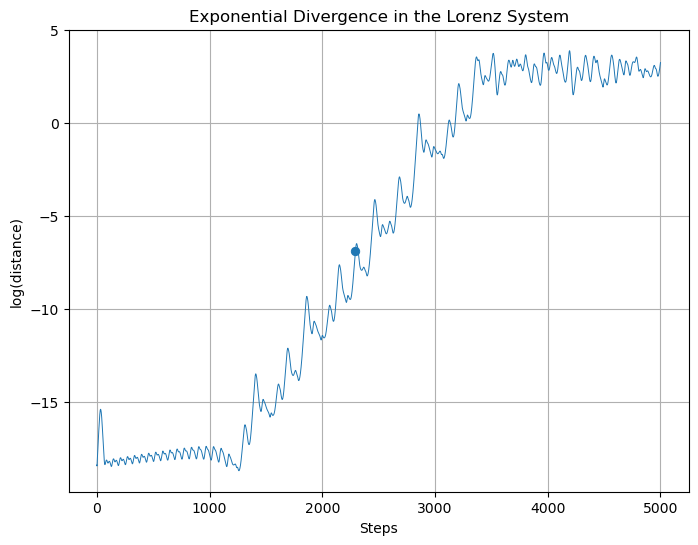

In [94]:
import torch
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64

# Two nearly identical initial conditions
init1 = torch.tensor([1.0, 1.0, 1.0], dtype=dtype, device=device)
init2 = init1 + torch.tensor([1e-8, 0.0, 0.0], dtype=dtype, device=device)

n_steps = 5000
dt = 0.01

# Integrate both trajectories
traj1 = integrate_lorenz(init1, n_steps, dt, device=device, dtype=dtype)[:, 0]
traj2 = integrate_lorenz(init2, n_steps, dt, device=device, dtype=dtype)[:, 0]

# Compute Euclidean distance between the two trajectories
dist = torch.norm(traj1 - traj2, dim=1).cpu().numpy()

threshold = 1e-3

# Find the first index where distance exceeds the threshold
idx = np.argmax(dist > threshold)

# Time array
time = np.arange(len(dist)) #* dt

# Plot divergence in log scale
plt.figure(figsize=(8, 6))
plt.plot(time, np.log(dist), linewidth=0.7)
plt.scatter(time[idx], np.log(dist[idx]), linewidth=0.7)
plt.xlabel("Steps")
plt.ylabel("log(distance)")
plt.title("Exponential Divergence in the Lorenz System")
plt.grid(True)
plt.show()

# Estimate Lyapunov exponent from linear region
# (the slope of log(distance) vs time)
#linear_region = slice(100, 800)   # avoid initial transient
#coef = np.polyfit(time[linear_region], np.log(dist[linear_region]), 1)
#lyapunov_estimate = coef[0]
#print("Estimated Largest Lyapunov Exponent:", lyapunov_estimate)


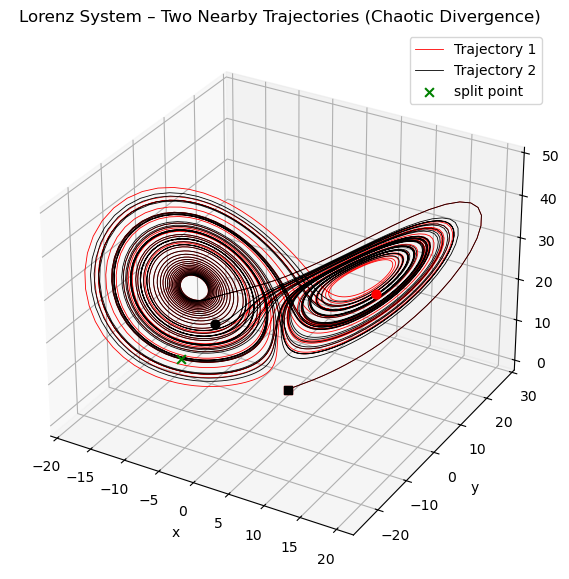

In [95]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert to NumPy for plotting
xyz1 = traj1.detach().cpu().numpy()   # shape (T, 3)
xyz2 = traj2.detach().cpu().numpy()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot trajectory 1
ax.plot(xyz1[:,0], xyz1[:,1], xyz1[:,2], lw=0.6, color='red', label='Trajectory 1')

# Plot trajectory 2
ax.plot(xyz2[:,0], xyz2[:,1], xyz2[:,2], lw=0.6, color='black', label='Trajectory 2')

# Mark start & end points
ax.scatter(xyz1[0,0], xyz1[0,1], xyz1[0,2], color='red', s=40, marker="s")      # start 1
ax.scatter(xyz1[-1,0], xyz1[-1,1], xyz1[-1,2], color='red', s=40, marker="o") # end 1

ax.scatter(xyz2[0,0], xyz2[0,1], xyz2[0,2], color='black', s=40, marker="s")      # start 2
ax.scatter(xyz2[-1,0], xyz2[-1,1], xyz2[-1,2], color='black', s=40, marker="o") # end 2


ax.scatter(xyz1[idx,0], xyz1[idx,1], xyz1[idx,2], color='green', s=40, marker="x", label="split point")      # start 1

ax.set_title("Lorenz System – Two Nearby Trajectories (Chaotic Divergence)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()

plt.show()


Now, solve optimization problem for t from 0 till split happens (no effect of chaos so far)

In [96]:
init = torch.tensor([1.0, 1.0, 1.0], dtype=torch.float64, requires_grad=True)
optimizer = torch.optim.Adam([init], lr=0.1)

target_final = torch.tensor([2.0, 1.0, 1.0], dtype=torch.float64)

dt = 0.01
n_steps = 1000

loss_hist = []

for step in range(1000):

    optimizer.zero_grad()

    # Integrate Lorenz forward from the *current* learnable initial condition
    traj = integrate_lorenz(
        initial_state=init,
        n_steps=n_steps,
        dt=dt,
        device=init.device,
        dtype=init.dtype
    )
    if step == 0:
        traj0 = traj.clone()

    final_state = traj[-1, 0]  # shape (3,)

    # Loss: L2 between final state and target
    loss = torch.nn.functional.mse_loss(final_state, target_final)

    # Backprop through the ODE solver
    loss.backward()

    optimizer.step()

    loss_hist.append(loss.item())

    if step % 20 == 0:
        print(f"step {step:03d} | loss = {loss.item():.6f} | init = {init.data}")


step 000 | loss = 210.484765 | init = tensor([1.1000, 1.1000, 0.9000], dtype=torch.float64)
step 020 | loss = 169.907160 | init = tensor([2.5059, 2.3096, 0.9859], dtype=torch.float64)
step 040 | loss = 158.450728 | init = tensor([3.7293, 3.3920, 1.1228], dtype=torch.float64)
step 060 | loss = 151.609953 | init = tensor([4.7879, 4.3148, 1.2521], dtype=torch.float64)
step 080 | loss = 146.886993 | init = tensor([5.7355, 5.0880, 1.4444], dtype=torch.float64)
step 100 | loss = 143.133122 | init = tensor([6.6258, 5.7913, 1.6257], dtype=torch.float64)
step 120 | loss = 139.964499 | init = tensor([7.4832, 6.4350, 1.8169], dtype=torch.float64)
step 140 | loss = 137.174915 | init = tensor([8.3225, 7.0289, 2.0203], dtype=torch.float64)
step 160 | loss = 134.643385 | init = tensor([9.1540, 7.5815, 2.2339], dtype=torch.float64)
step 180 | loss = 132.290522 | init = tensor([9.9852, 8.0964, 2.4585], dtype=torch.float64)
step 200 | loss = 130.059384 | init = tensor([10.8222,  8.5768,  2.6941], dtype=

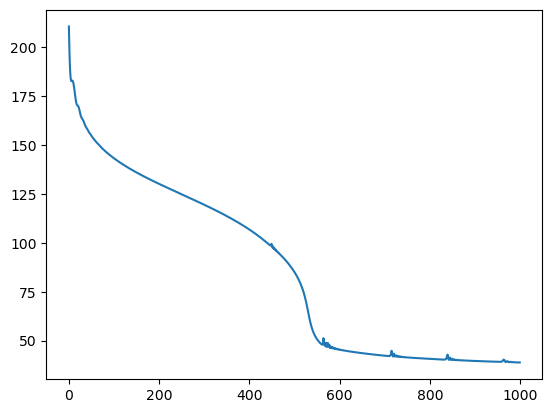

In [97]:
plt.plot(loss_hist)

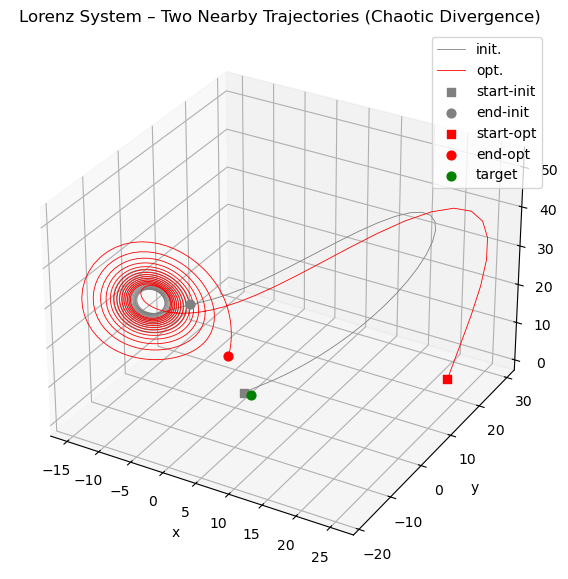

In [98]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert to NumPy for plotting
xyz1 = traj0.squeeze().detach().cpu().numpy()   # shape (T, 3)
xyz2 = traj.squeeze().detach().cpu().numpy()   # shape (T, 3)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot trajectory 1
ax.plot(xyz1[:,0], xyz1[:,1], xyz1[:,2], lw=0.6, color='grey', label='init.')
ax.plot(xyz2[:,0], xyz2[:,1], xyz2[:,2], lw=0.6, color='red', label='opt.')

# Mark start & end points
ax.scatter(xyz1[0,0], xyz1[0,1], xyz1[0,2], color='grey', s=40, marker="s", label="start-init")      # start 1
ax.scatter(xyz1[-1,0], xyz1[-1,1], xyz1[-1,2], color='grey', s=40, marker="o", label="end-init") # end 1

ax.scatter(xyz2[0,0], xyz2[0,1], xyz2[0,2], color='red', s=40, marker="s", label="start-opt")      # start 1
ax.scatter(xyz2[-1,0], xyz2[-1,1], xyz2[-1,2], color='red', s=40, marker="o", label="end-opt") # end 1


ax.scatter(target_final[0], target_final[1], target_final[2], color='green', s=40, marker="o", label="target")      # start 1

ax.set_title("Lorenz System – Two Nearby Trajectories (Chaotic Divergence)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()

plt.show()


## Second test: Solve optimization problem for longer time
Even after trajectories diverge (chaos happenning)

In [99]:
import torch
import copy

init = torch.tensor([1.0, 1.0, 1.0], dtype=torch.float64, requires_grad=True)
optimizer = torch.optim.Adam([init], lr=0.1)

target_final = torch.tensor([2.0, 1.0, 1.0], dtype=torch.float64)

dt = 0.01
n_steps = 5000

loss_hist = []

best_loss = float("inf")
best_init = None
best_traj = None
best_step = None

for step in range(1000):

    optimizer.zero_grad()

    # Integrate Lorenz forward from the *current* learnable initial condition
    traj = integrate_lorenz(
        initial_state=init,
        n_steps=n_steps,
        dt=dt,
        device=init.device,
        dtype=init.dtype
    )

    if step == 0:
        traj0 = traj.clone()

    final_state = traj[-1, 0]  # shape (3,)

    # Loss: L2 between final state and target
    loss = torch.nn.functional.mse_loss(final_state, target_final)

    # Backprop through the ODE solver
    loss.backward()
    optimizer.step()

    loss_hist.append(loss.item())

    # ---- SAVE BEST SOLUTION ----
    if loss.item() < best_loss:
        best_loss = loss.item()

        # Detach and clone to avoid graph references
        best_init = init.detach().clone()
        best_traj = traj.detach().clone()
        best_step = step

    if step % 20 == 0:
        print(f"step {step:03d} | loss = {loss.item():.6f} | init = {init.data}")


print("\n============================")
print("Training finished!")
print(f"Best loss: {best_loss:.6f} at step {best_step}")
print(f"Best initial condition: {best_init}")
print("============================")


step 000 | loss = 194.888856 | init = tensor([0.9000, 0.9000, 0.9000], dtype=torch.float64)
step 020 | loss = 197.998903 | init = tensor([1.2509, 1.2644, 1.2509], dtype=torch.float64)
step 040 | loss = 186.253005 | init = tensor([0.7520, 0.7664, 0.7519], dtype=torch.float64)
step 060 | loss = 128.080464 | init = tensor([0.7227, 0.7529, 0.7228], dtype=torch.float64)
step 080 | loss = 92.452553 | init = tensor([0.7253, 0.7601, 0.7254], dtype=torch.float64)
step 100 | loss = 357.075066 | init = tensor([0.7227, 0.7572, 0.7228], dtype=torch.float64)
step 120 | loss = 218.840383 | init = tensor([0.7187, 0.7520, 0.7188], dtype=torch.float64)
step 140 | loss = 79.586113 | init = tensor([0.7143, 0.7462, 0.7143], dtype=torch.float64)
step 160 | loss = 67.219493 | init = tensor([0.7172, 0.7501, 0.7173], dtype=torch.float64)
step 180 | loss = 163.853242 | init = tensor([0.7160, 0.7485, 0.7160], dtype=torch.float64)
step 200 | loss = 174.243485 | init = tensor([0.7178, 0.7509, 0.7179], dtype=torch.

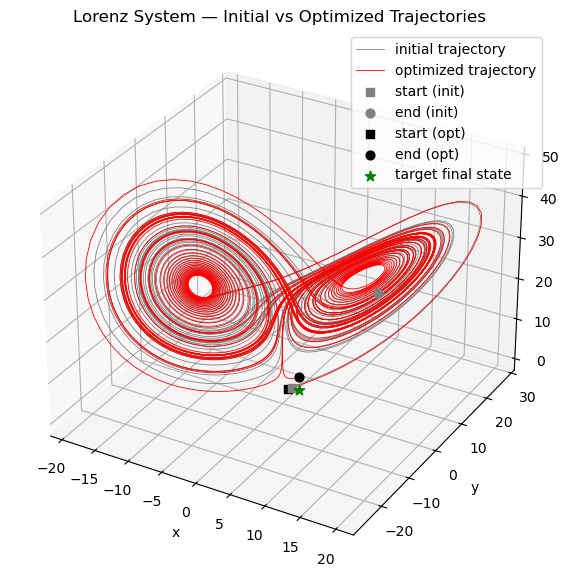

In [100]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert to NumPy for plotting
xyz1 = traj0.squeeze().detach().cpu().numpy()     # initial trajectory
xyz2 = best_traj.squeeze().detach().cpu().numpy() # best trajectory found during training

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot trajectories
ax.plot(xyz1[:,0], xyz1[:,1], xyz1[:,2], lw=0.6, color='grey', label='initial trajectory')
ax.plot(xyz2[:,0], xyz2[:,1], xyz2[:,2], lw=0.6, color='red', label='optimized trajectory')

# Mark start & end points
ax.scatter(xyz1[0,0], xyz1[0,1], xyz1[0,2], color='grey', s=40, marker="s", label="start (init)")
ax.scatter(xyz1[-1,0], xyz1[-1,1], xyz1[-1,2], color='grey', s=40, marker="o", label="end (init)")

ax.scatter(xyz2[0,0], xyz2[0,1], xyz2[0,2], color='black', s=40, marker="s", label="start (opt)")
ax.scatter(xyz2[-1,0], xyz2[-1,1], xyz2[-1,2], color='black', s=40, marker="o", label="end (opt)")

# Target point
ax.scatter(
    target_final[0], target_final[1], target_final[2],
    color='green', s=60, marker="*", label="target final state"
)

ax.set_title("Lorenz System — Initial vs Optimized Trajectories")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()

plt.show()


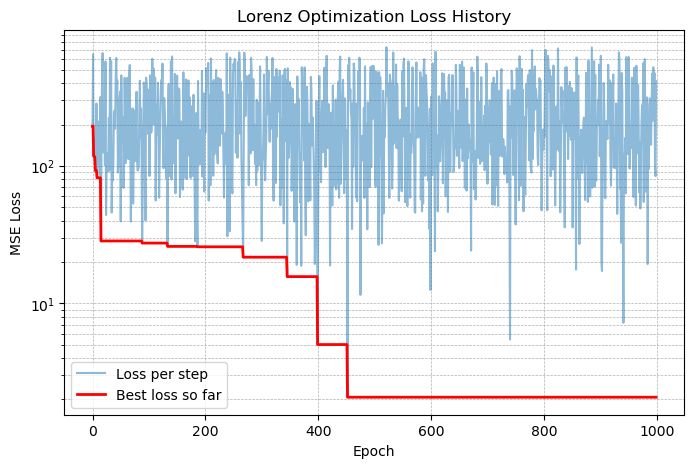

In [101]:
import matplotlib.pyplot as plt
import numpy as np

loss_hist_np = np.array(loss_hist)  # convert to numpy

# Compute running minimum
running_min = np.minimum.accumulate(loss_hist_np)

plt.figure(figsize=(8,5))
plt.plot(loss_hist_np, label="Loss per step", alpha=0.5)
plt.plot(running_min, label="Best loss so far", color='red', linewidth=2)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Lorenz Optimization Loss History")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()
